# Crazy Test Machine

Inspired by: https://www.youtube.com/watch?v=dWmJ5CXSKdw&ab_channel=NicholasRenotte

## Install Dependencies

In [1]:
# Change according to your needs: https://pytorch.org/get-started/locally/
# %pip install torch torchvision torchaudio
# %pip install gym
# %pip install stable-baselines3[extra]
# %pip install protobuf==3.20.*
# %pip install mss
# %pip install Pillow
# %pip install pytesseract
# %pip install pydirectinput

## Game Environment

### Create Environment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

from gym import Env
from gym.spaces import Box, Discrete

import pygame
pygame.init()

from mss import mss
import cv2

import pydirectinput

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\allem\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

In [3]:
class CrazyEnv(Env):
    def __init__(self):
        super().__init__()

        # Observation
        self.screen_width, self.screen_height, self.window_width, self.window_height = self.getDimensions()
        self.x = int((self.screen_width - self.window_width) / 2) + 190
        self.y = int(90 / 2) + 100
        self.rescaled_width = int(self.window_width / 2)
        self.rescaled_height = int(self.window_height / 2)
        self.observation_space = Box(low=0, high=255, shape=(1,self.rescaled_height,self.rescaled_width), dtype=np.uint8)
        self.action_space = Discrete(3)

        # Action map
        self.action_map = {
            0: "no_op",
            1: "left",
            2: "right"
        }

        self.cap = mss()
        self.monitor_number = 2 # Change according to screen set-up
        self.monitor = self.cap.monitors[self.monitor_number]
        self.game_location = {"top": self.monitor["top"] + self.y,
                              "left": self.monitor["left"] + self.x,
                              "width": self.window_width,
                              "height": self.window_height,
                              "mon": self.monitor_number}
        self.done_location = {"top": self.monitor["top"] + self.y + 55,
                              "left": self.monitor["left"] + self.x,
                              "width": self.window_width,
                              "height": 55,
                              "mon": self.monitor_number}
        self.observation = None
        self.done_reference = np.loadtxt("done_reference.txt").astype(np.uint8)

    def getDimensions(self):
        infoObject = pygame.display.Info()
        screen_height = infoObject.current_h
        screen_width = infoObject.current_w
        correction = 90
        window_height = infoObject.current_h-correction
        window_width = int(((window_height)*9)/16)
        return screen_width, screen_height, window_width, window_height

    def step(self, action, verbose=False):
        if action != 0:
            pydirectinput.press(self.action_map[action])

        # Check for end of the game
        done = self.isDone(verbose=verbose)
        # Get the next observation
        self.observation = self.getObservation()
        # Reward
        reward = 1
        # Info
        info = {}

        return self.observation, reward, done, info

    def render(self):
        if self.observation is None:
            self.observation = self.getObservation()

        cv2.imshow("Game", self.observation[0])
        if cv2.waitKey(1) & 0xFF == ord("q"):
            self.close()

    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=self.monitor["left"] + self.x + 50, y=self.monitor["top"] + self.y + 50)
        pydirectinput.press("up")
        return self.getObservation()

    def close(self):
        cv2.destroyAllWindows()

    def getObservation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (self.rescaled_width,self.rescaled_height))
        processed = np.reshape(resized, (1,self.rescaled_height,self.rescaled_width))
        return processed

    def getDone(self):
        raw = np.array(self.cap.grab(self.done_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        return gray
    
    # def isDone(self, verbose=False):
    #     # Valid text
    #     valid_text = ["GAME", "GAHE"]

    #     done = False
    #     text = ""
    #     try:
    #         text = pytesseract.image_to_string(self.getDone(), timeout=1)
    #     except RuntimeError as timeout_error:
    #         print("Pytessract timeout...")
    #     if verbose:
    #         print("Done text:", text)
    #     if text[:4] in valid_text:
    #         if verbose:
    #             print("Valid done text:", text)
    #         done = True

    #     return done

    def isDone(self, verbose=False):
        if np.allclose(self.done_reference, self.getDone()):
            return True
        return False

### Test Environment

In [4]:
test_env = CrazyEnv()

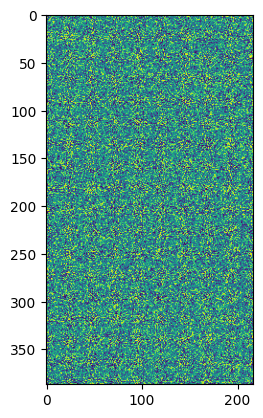

In [5]:
plt.imshow(test_env.observation_space.sample()[0])

In [6]:
test_env.action_space.sample()

1

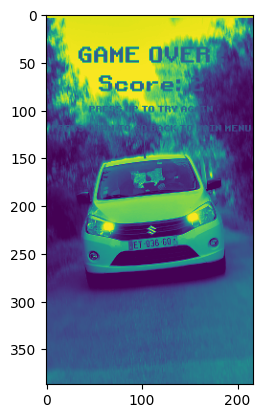

In [7]:
plt.imshow(test_env.getObservation()[0])
# plt.imshow(cv2.cvtColor(test_env.getObservation()[0], cv2.COLOR_BGR2RGB))

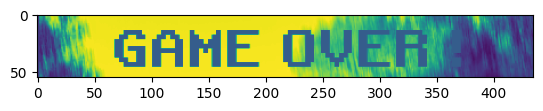

In [8]:
plt.imshow(test_env.getDone())

In [9]:
text = pytesseract.image_to_string(test_env.getDone())
print(text)

In [10]:
done_reference = np.array(test_env.cap.grab(test_env.done_location))[:,:,:3].astype(np.uint8)
done_reference = cv2.cvtColor(done_reference, cv2.COLOR_BGR2GRAY)
# np.savetxt("done_reference.txt", done_reference)
if np.allclose(done_reference, test_env.done_reference):
    print("OK")
else:
    print("NOK")
    print(done_reference.shape)
    print(test_env.done_reference.shape)

OK


In [11]:
test_env.render()

In [12]:
test_env.close()

In [13]:
for episode in range(10):
    obs = test_env.reset()
    done = False
    total_reward = 0

    while not done:
        obs, reward, done, info = test_env.step(test_env.action_space.sample(), verbose=True)
        total_reward += reward
    print(f"Episode {episode}: total_reward = {total_reward}")

Episode 0: total_reward = 84
Episode 1: total_reward = 63
Episode 2: total_reward = 36
Episode 3: total_reward = 9


KeyboardInterrupt: 

## Create AI Model

### Callback

In [15]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

ModuleNotFoundError: No module named 'stable_baselines3'

In [ ]:
# Check environment
env_checker.check_env(test_env)

In [1]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=True):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "model_{}".format(self.n_calls))
            self.model.save(model_path)
        return True

NameError: name 'BaseCallback' is not defined

In [2]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"

In [3]:
callback = TrainAndLoggingCallback(check_freq=500000, save_path=CHECKPOINT_DIR)

NameError: name 'TrainAndLoggingCallback' is not defined

### DQN Model

In [ ]:
from stable_baselines3 import DQN

In [ ]:
TOTAL_TIMESTEPS = 1000000

crazy_env = CrazyEnv()

model = DQN("CnnPolicy", crazy_env, tensorboard_log=LOG_DIR, verbose=True, buffer_size=1200000, learning_starts=10)

In [ ]:
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback)

In [ ]:
# model.load(os.path.join(CHECKPOINT_DIR, "model_{}".format(TOTAL_TIMESTEPS)))

In [ ]:
for episode in range(10):
    obs = crazy_env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = crazy_env.step(int(action), verbose=True)
        total_reward += reward
    print(f"Episode {episode}: total_reward = {total_reward}")